In [4]:
!git clone git@github.com:samebanimb/Reinforcement_learning_pendulum.git


fatal: destination path 'pendulum_gym_env' already exists and is not an empty directory.


In [5]:
import os

os.chdir('/content/Reinforcement_learning_pendulum')
print(os.listdir())

['trained-agent.mp4', '.pre-commit-config.yaml', '.gitignore', 'DDPG_pendulum', '.git', 'trained-agent-training-environment.mp4', 'testing.ipynb', 'README.md', 'setup.py', 'pendulum_environment.egg-info', 'pendulum_environment', 'requirements.txt']


In [6]:
!cd /content/Reinforcement_learning_pendulum/ & pip install -e .


Obtaining file:///content/pendulum_gym_env
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install matplotlib
!pip install tf-keras
!pip install ipdb
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install --upgrade dm-reverb[tensorflow]

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,589 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,440 kB]
Hit:14 https://ppa.launchpadcontent.net/

In [7]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tempfile
import reverb
import tensorflow as tf
import pendulum_environment
import ipdb
import pyvirtualdisplay


from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.td3 import td3_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import parallel_py_environment
from tf_agents.environments import suite_mujoco
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import normal_projection_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.environments import suite_gym
import tf_agents
import time
import pickle
import scipy.io
from google.colab import files

from absl import logging


##https://github.com/tensorflow/agents/issues/275

In [8]:
# Function to create a mp4 file in the notebook
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# function to create a mp4 file from the simulation of the environment
def create_policy_eval_video(tf_environment, py_environment, policy, filename, num_episodes=5, fps=20):
  filename = filename + ".mp4"
  actions = []
  with imageio.get_writer(filename, fps=fps) as video:
    for k in range(num_episodes):
      time_step = tf_environment.reset()
      video.append_data(py_environment.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = tf_environment.step(action_step.action)
        video.append_data(py_environment.render())
        if k==num_episodes-1:
          actions.append(action_step.action[0])
    plt.plot(actions)
  return embed_mp4(filename)

In [9]:
root_dir = "DDPG_pendulum/"
env_original_name = "pendulum_environment/Pendulum-v0"
env_name = env_original_name
#env_name = 'Pendulum-v1'
#env_eval_name = 'Pendulum-v1'
_DEFAULT_REWARD_SCALE = 1.
num_iterations_training=400000
actor_fc_layers=(400, 300)
critic_obs_fc_layers=(256, 256)
critic_action_fc_layers=(256,)
critic_joint_fc_layers=( 512,256)
num_parallel_environments=1
# Params for collect
initial_collect_steps=100
collect_steps_per_iteration=1
replay_buffer_capacity=50000
# Params for target update
target_update_tau=0.01
target_update_period=1
# Params for train
train_steps_per_iteration=1
batch_size=64
actor_learning_rate=1e-4
critic_learning_rate=1e-3
alpha_learning_rate=1e-4
td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error
gamma=0.9
reward_scale_factor=_DEFAULT_REWARD_SCALE
gradient_clipping=None
use_tf_functions=True
# Params for eval
num_eval_episodes = 10
eval_interval=10000
# Params for summaries and logging
train_checkpoint_interval=500000
policy_checkpoint_interval=500000
rb_checkpoint_interval=500000
log_interval=1000
summary_interval=2000
summaries_flush_secs=10
debug_summaries=False
summarize_grads_and_vars=False
eval_metrics_callback=None

logging.set_verbosity(logging.INFO)

In [10]:
def normal_projection_net(action_spec,
                          init_action_stddev=0.35,
                          init_means_output_factor=0.1):
  del init_action_stddev
  return normal_projection_network.NormalProjectionNetwork(
      action_spec,
      mean_transform=None,
      state_dependent_std=True,
      init_means_output_factor=init_means_output_factor,
      #std_transform=tf.nn.softplus,
      scale_distribution=True)

In [11]:
root_dir = os.path.expanduser(root_dir)

summary_writer = tf.compat.v2.summary.create_file_writer(
      root_dir, flush_millis=summaries_flush_secs * 1000)
summary_writer.set_as_default()

eval_metrics = [
  tf_metrics.AverageReturnMetric(buffer_size=num_eval_episodes),
  tf_metrics.AverageEpisodeLengthMetric(buffer_size=num_eval_episodes)
]

global_step = tf.compat.v1.train.get_or_create_global_step()

py_env = suite_gym.load(env_name)
tf_env = tf_py_environment.TFPyEnvironment(py_env)


In [12]:


time_step_spec = tf_env.time_step_spec()
observation_spec = time_step_spec.observation
action_spec = tf_env.action_spec()


actor_net = tf_agents.agents.ddpg.actor_network.ActorNetwork(
    observation_spec, action_spec, fc_layer_params=actor_fc_layers,

)

critic_net = tf_agents.agents.ddpg.critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=critic_obs_fc_layers,
    action_fc_layer_params=critic_action_fc_layers,
    joint_fc_layer_params=critic_joint_fc_layers)


tf_agent = tf_agents.agents.DdpgAgent(
    time_step_spec,
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=td_errors_loss_fn,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()

In [13]:


# Make the replay buffer.
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=num_parallel_environments,
    max_length=replay_buffer_capacity)
replay_observer = [replay_buffer.add_batch]

env_steps = tf_metrics.EnvironmentSteps(prefix='Train')

average_return = tf_metrics.AverageReturnMetric(
    prefix='Train',
    buffer_size=num_eval_episodes,
    batch_size=tf_env.batch_size)

train_metrics = [
    tf_metrics.NumberOfEpisodes(prefix='Train'),
    env_steps,
    average_return,
    tf_metrics.AverageEpisodeLengthMetric(
        prefix='Train',
        buffer_size=num_eval_episodes,
        batch_size=tf_env.batch_size),
]

eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)

initial_collect_policy = random_tf_policy.RandomTFPolicy(
    tf_env.time_step_spec(), tf_env.action_spec())

collect_policy = tf_agent.collect_policy

train_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(root_dir, 'train'),
    agent=tf_agent,
    global_step=global_step,
    metrics=metric_utils.MetricsGroup(train_metrics, 'train_metrics'))
policy_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(root_dir, 'policy'),
    policy=eval_policy,
    global_step=global_step)
rb_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(root_dir, 'replay_buffer'),
    max_to_keep=1,
    replay_buffer=replay_buffer)

train_checkpointer.initialize_or_restore()

rb_checkpointer.initialize_or_restore()

initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=replay_observer + train_metrics,
    num_steps=initial_collect_steps)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env,
    collect_policy,
    observers=replay_observer + train_metrics,
    num_steps=collect_steps_per_iteration)

initial_collect_driver.run = common.function(initial_collect_driver.run)
collect_driver.run = common.function(collect_driver.run)
tf_agent.train = common.function(tf_agent.train)

INFO:absl:No checkpoint available at DDPG_pendulum/train
INFO:absl:No checkpoint available at DDPG_pendulum/policy
INFO:absl:No checkpoint available at DDPG_pendulum/replay_buffer


In [14]:
# Collect initial replay data.
if env_steps.result() == 0 or replay_buffer.num_frames() == 0:
    logging.info(
      'Initializing replay buffer by collecting experience for %d steps'
      'with a random policy.', initial_collect_steps)
    initial_collect_driver.run()

INFO:absl:Initializing replay buffer by collecting experience for 100 stepswith a random policy.


In [15]:
def train_step():
  experience, _ = next(iterator)
  return tf_agent.train(experience)



In [16]:
results = metric_utils.eager_compute(
    eval_metrics,
    tf_env,
    eval_policy,
    num_episodes=num_eval_episodes,
    train_step=env_steps.result(),
    summary_writer=summary_writer,
    summary_prefix='Eval',
)
if eval_metrics_callback is not None:
  eval_metrics_callback(results, env_steps.result())
metric_utils.log_metrics(eval_metrics)

time_step = None
policy_state = collect_policy.get_initial_state(tf_env.batch_size)

time_acc = 0
env_steps_before = env_steps.result().numpy()

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

train_step = common.function(train_step)

INFO:absl: 
		 AverageReturn = 17.28620719909668
		 AverageEpisodeLength = 500.0
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [17]:
try:
  %%time
except:
  pass
start_time = time.time()
# Reset the train step
tf_agent.train_step_counter.assign(0)

#Evaluate the agent's policy once before training.
avg_return = average_return.result()
returns_training = [avg_return]


for _ in range(num_iterations_training):
  start_time = time.time()
  time_step, policy_state = collect_driver.run(
      time_step=time_step,
      policy_state=policy_state,
  )
  for _ in range(train_steps_per_iteration):
    train_step()
  time_acc += time.time() - start_time

  if global_step.numpy() % log_interval == 0:
    logging.info('env steps = %d, average return = %f', env_steps.result(),
                 average_return.result())
    env_steps_per_sec = (env_steps.result().numpy() -
                         env_steps_before) / time_acc
    logging.info('%.3f env steps/sec', env_steps_per_sec)
    tf.compat.v2.summary.scalar(
        name='env_steps_per_sec',
        data=env_steps_per_sec,
        step=env_steps.result())
    time_acc = 0
    env_steps_before = env_steps.result().numpy()
    returns_training.append(average_return.result().numpy())

  for train_metric in train_metrics:
    train_metric.tf_summaries(train_step=env_steps.result())

  if global_step.numpy() % eval_interval == 0:
    results = metric_utils.eager_compute(
        eval_metrics,
        tf_env,
        eval_policy,
        num_episodes=num_eval_episodes,
        train_step=env_steps.result(),
        summary_writer=summary_writer,
        summary_prefix='Eval',
    )
    #returns_training.append(results['AverageReturn'].numpy())
    if eval_metrics_callback is not None:
      eval_metrics_callback(results, env_steps.result())
    metric_utils.log_metrics(eval_metrics)
    global_step_val = global_step.numpy()
    if global_step_val % train_checkpoint_interval == 0:
        train_checkpointer.save(global_step=global_step_val)
    if global_step_val % policy_checkpoint_interval == 0:
        policy_checkpointer.save(global_step=global_step_val)
    if global_step_val % rb_checkpoint_interval == 0:
        rb_checkpointer.save(global_step=global_step_val)

end_time = time.time()
duration = end_time - start_time
print(f"Duration: {duration} seconds")

INFO:absl:env steps = 1100, average return = 23.577114
INFO:absl:33.165 env steps/sec
INFO:absl:env steps = 2100, average return = 33.435768
INFO:absl:47.106 env steps/sec
INFO:absl:env steps = 3100, average return = 35.798615
INFO:absl:47.208 env steps/sec
INFO:absl:env steps = 4100, average return = 50.381283
INFO:absl:45.933 env steps/sec
INFO:absl:env steps = 5100, average return = 29.473059
INFO:absl:46.892 env steps/sec
INFO:absl:env steps = 6100, average return = 42.260841
INFO:absl:49.711 env steps/sec
INFO:absl:env steps = 7100, average return = 40.623928
INFO:absl:43.631 env steps/sec
INFO:absl:env steps = 8100, average return = 36.202141
INFO:absl:46.980 env steps/sec
INFO:absl:env steps = 9100, average return = 37.378738
INFO:absl:47.036 env steps/sec
INFO:absl:env steps = 10100, average return = 33.338718
INFO:absl:50.632 env steps/sec
INFO:absl: 
		 AverageReturn = 29.421245574951172
		 AverageEpisodeLength = 54.79999923706055
INFO:absl:env steps = 11100, average return =

Duration: 7.04216194152832 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

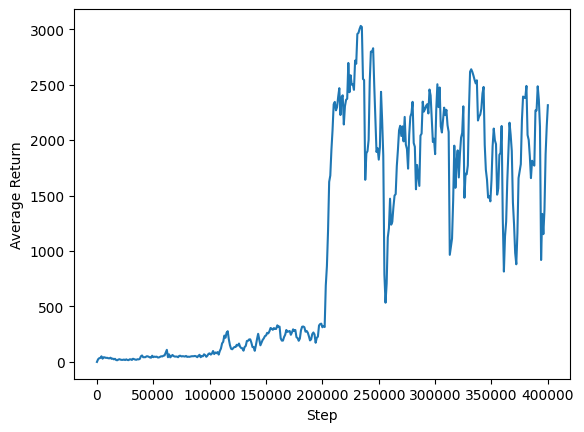

In [18]:
steps = range(0, num_iterations_training + 1, log_interval)
plt.plot(steps, returns_training)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()
with open(os.path.join(root_dir, 'returns_training_batch_64_3.pkl'), 'wb') as f:
  pickle.dump((returns_training, steps), f)

files.download(os.path.join(root_dir, 'returns_training_batch_64_3.pkl'))

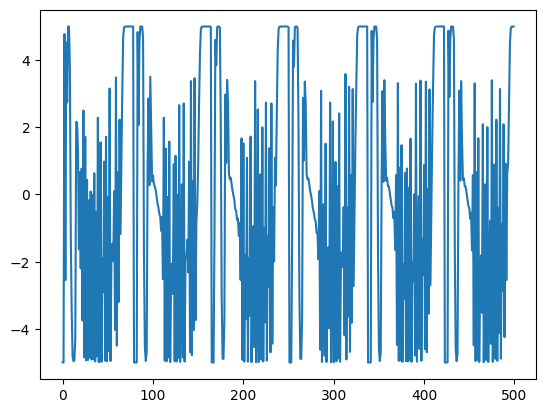

In [19]:

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900))
display.start()
create_policy_eval_video(tf_env, py_env, tf_agent.policy, "trained-agent-training-environment")



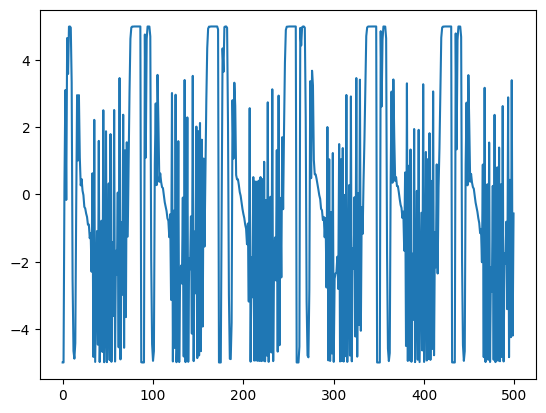

In [20]:
create_policy_eval_video(eval_tf_env, eval_py_env, tf_agent.policy, "trained-agent")



In [20]:
import scipy.io
from google.colab import files
actor_network = tf_agent._actor_network
actor_weights = actor_network.get_weights()

# Save the file and specify the full path
scipy.io.savemat('/content/actor_weights.mat', {'weights': actor_weights})
# Download the file using the same path that it was saved with
files.download("/content/actor_weights.mat")